This notebook detects IEDs using different parameters.

In [1]:
import mne
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import math
import pyedflib
import random
import os
from bisect import bisect_left
import h5py

matplotlib.rcParams['figure.figsize'] = (10, 2)
mne.set_log_level('WARNING')

%run DetectSpike_SEEG.py

Open the file

In [2]:
# file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
file_name = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'

f = pyedflib.EdfReader(file_name)

In [198]:
file_name = 'Data/IED_P001.mat'

with h5py.File(file_name, 'r') as f:
    data = np.array(f['d'])
    freq = np.array(f['fs'])
    gs_chan = np.array(f['REV_GS']['chan'])
    gs_con = np.array(f['REV_GS']['con'])
    gs_dur = np.array(f['REV_GS']['dur'])
    gs_pos = np.array(f['REV_GS']['pos'])

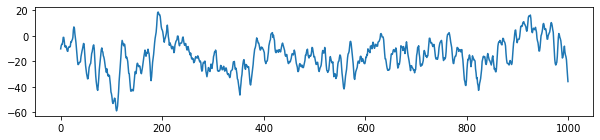

In [203]:
plt.plot(data[0][:1000])

In [157]:
# Detect IEDs in current block across all chanels
SpikeIndex, ChanId, _ = DetectSpikes(data, int(freq), DetThresholds=[7, 7, 300, 10, 10])

In [ ]:
tol = 0.05

def getRange(mz1, tol):
    return mz1 - tol, mz1 + tol

def sensitivity(l1, l2):
    d = { mz1:[] for mz1 in l1 }
    for mz1 in l1:
        lo,hi = getRange(mz1, tol)
        i = bisect_left(l2,lo)
        while i < len(l2) and l2[i]<= hi:
            d[mz1].append(l2[i])
            i+=1
            
    tp = 0
    fp = 0
    ieds = 0

    for key in d:
        ieds += 1
        if len(d[key]) > 0:
            tp += 1
        else:
            fp += 1

    return tp, fp, ieds
    

file_names = [i for i in os.listdir(path) if \
              os.path.isfile(os.path.join(path,i)) and \
              i.startswith('IED') and i.endswith('mat')]

sensitivities = []
ppvs = []
f1s = []
max_f1 = 0

for STDCoeff in range(2, 6, 1):
    for SCALE in range(50, 100, 10):
        for TroughSearch in range(30, 55, 5):
            for file_name in file_names:
                with h5py.File(os.path.join(path, file_name), 'r') as f:
                    gs_chan = np.array(f['REV_GS']['chan'])
                    gs_con = np.array(f['REV_GS']['con'])
                    gs_dur = np.array(f['REV_GS']['dur'])
                    gs_pos = np.array(f['REV_GS']['pos'])
                    data = np.array(f['d'])
                    freq = np.array(f['fs'])

                # Detect IEDs in current block across all chanels
                SpikeIndex, ChanId, _ = DetectSpikes(data, int(freq), STDCoeff=STDCoeff, SCALE=SCALE, TroughSearch=TroughSearch)

                tp = 0
                fp = 0
                fn = 0

                for i in range(data.shape[0]):

                    l1 = np.sort(SpikeIndex[ChanId == i] / freq)[0]
                    l2 = np.sort(gs_pos[np.logical_and(gs_chan == i+1, gs_con == 1)])

                    chan_tp, chan_fp, _ = sensitivity(l1, l2)

                    tp += chan_tp
                    fp += chan_fp

                    fn += sensitivity(l2, l1)[1]

                if tp + fn > 0:
                    sensitivities.append(tp/(tp+fn))
                else:
                    sensitivities.append(0)

                if tp + fp > 0:
                    ppvs.append(tp/(tp+fp))
                else:
                    ppvs.append(0)
                    
                if tp+0.5*(fp+fn) > 0:
                    f1s.append(tp/(tp+0.5*(fp+fn)))
                else:
                    f1s.append(0)

            f1 = np.array(f1s).mean()
            if f1 > max_f1:
                best_params = {
                    "STDCoeff": STDCoeff,
                    "SCALE": SCALE,
                    "TroughSearch": TroughSearch
                }
            print(f1, np.array(sensitivities).mean(), np.array(ppvs).mean())
            
print(best_params)

In [99]:
l2  = np.sort(SpikeIndex[ChanId == 4] / freq)[0]
l1  = np.sort(gs_pos[np.logical_and(gs_chan == 5, gs_con == 1)])

from bisect import bisect_left
d = { mz1:[] for mz1 in l1 }
for mz1 in l1:
    lo,hi = getRange(mz1, tol)
    i = bisect_left(l2,lo)
    while i < len(l2) and l2[i]<= hi:
        d[mz1].append(l2[i])
        i+=1
        
tp = 0
total = 0

for key in d:
    if len(d[key]) > 0:
        tp += 1
        total += 1
    else:
        total += 1
        
print("Specificity:", tp/total)

Specificity: 0.7222222222222222


array([  9.852,  18.196,  28.432,  28.64 ,  38.244,  40.456,  80.08 ,
        84.052,  87.332,  90.352,  93.076, 105.784, 114.496, 114.784,
       118.74 , 126.136, 126.412, 126.68 , 134.656, 139.284, 142.592,
       147.78 , 154.076, 154.192, 158.16 , 164.532, 164.952, 166.46 ,
       166.72 , 172.476, 174.292, 179.764, 183.312, 188.04 , 188.344,
       188.992, 191.604, 193.552, 193.692, 195.284, 197.452, 199.512,
       202.152, 205.584, 205.972, 207.32 , 209.672, 210.56 , 216.224,
       219.316, 225.436, 225.72 , 226.492, 228.944, 229.384, 229.936,
       230.172, 230.544, 234.996, 235.356, 237.104, 242.52 , 242.84 ,
       243.132, 244.06 , 244.932, 249.416, 251.256, 255.96 , 257.264,
       259.116, 262.12 , 262.636, 264.616, 267.976, 268.732, 272.652,
       275.572, 276.632, 277.816, 280.416, 281.536, 281.916, 282.436,
       284.992, 287.232, 289.352, 290.712, 297.476, 298.064])

In [18]:
75000/250

300.0

Define file specific parameters

In [3]:
freq = 2048
ref_chan = 'EEG 07'

Get channels and number of channels

In [4]:
num_chans = f.signals_in_file  # change to valid_channels.shape[0]
signal_labels = f.getSignalLabels()

Get list of channels to use from channels.mat

In [5]:
# Load file containing suitable channels and convert to list
mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

# valid_channels = signal_labels

Process a random minute of data with a range of params and select random 5s segments in random channels to show detections for each set of params.

28 EEG I4 2


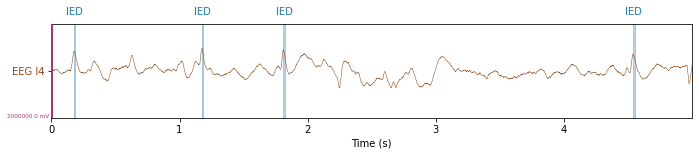

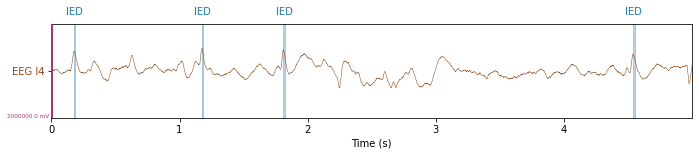

In [9]:
# Process 1 minute at a time
mins_to_process = 1

M = f.getNSamples()[0]# / (freq * 60)

NumSecs = M / freq
Blocks = math.floor(NumSecs / (mins_to_process * 60))

def generate_detections(DetThresholds_list):
    
    # Randomly choose a minute to select data from
    minute = random.randrange(Blocks)
    minute = 28
    
    data_block = np.zeros((len(valid_channels), freq * 60 * mins_to_process))

#     reference = f.readSignal(signal_labels.index(ref_chan), \
#                              start = minute * freq * 60 * mins_to_process, \
#                              n = freq * 60 * mins_to_process)

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels):

        data_block[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = minute * freq * 60 * mins_to_process, \
                                        n = freq * 60 * mins_to_process)# - reference
        
    # Index of channel to consider
    chan = random.choices(valid_channels)[0]
    chan = 'EEG I4'
    
    # Randomly select a 5 second segment within the minute of data to show detections for (note: 12 blocks of 5s)
    five_second_segment = random.randrange(12)
    five_second_segment = 2
    
    print(minute, chan, five_second_segment)
    
    for DetThresholds in DetThresholds_list:
        # Detect IEDs in current block across all chanels
        SpikeIndex, ChanId, _ = DetectSpikes(data_block, freq,\
                                             STDCoeff=DetThresholds)

        info = mne.create_info([chan], freq, ch_types='seeg')
        data = mne.io.RawArray(data = [data_block[valid_channels.index(chan)] \
                                       [five_second_segment * freq * 5 : \
                                        (five_second_segment + 1) * freq * 5]], info = info)

        onsets = []
        durations = []
        descriptions = []
        
        SpikeIds_from_zero = SpikeIndex - five_second_segment * freq * 5
        spike_indices = np.logical_and(ChanId == valid_channels.index(chan), SpikeIds_from_zero < 5 * freq)
        
        for spike in SpikeIds_from_zero[spike_indices]:
            if spike > 0:
                onsets.append(spike / 2048)
                durations.append(0.01)
                descriptions.append('IED')

        my_annot = mne.Annotations(onset=onsets,  # in seconds
                                   duration=durations,  # in seconds, too
                                   description=descriptions)

        data = data.set_annotations(my_annot)

        # test = data.plot(start=20, duration=2, n_channels=6, scalings=dict(eeg=5e-4))
        fig = data.plot(scalings=dict(seeg=1e3), show_scrollbars=False)

        plt.show()
        
DetThresholds_list = [[7, 7, 200, 10, 10],
                      [7, 7, 400, 10, 10],
                      [7, 7, 600, 10, 10],
                      [7, 7, 800, 10, 10]]

STDCoeff_list = [2, 3]

SCALE_list = [70]

# generate_detections(DetThresholds_list)
generate_detections(STDCoeff_list)

Det Thresholds: [7, 7, 600, 10, 10]

7 seems fine for the first two arguments. Definitely not 9. (explored 5-9)

STDCoeff: 3 seems okay (explored 2-6). 2 has less false negatives, but more false positives.

scales of 60-90 so far (explored 50-90). 70 seems good.